In [1]:
# training on P100: 849MB memory, training loss decrease slow
# training on V100: 1255MB memory, training loss decrease much faster

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from google.colab import drive
drive.mount('/content/drive')
device='cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_name(0))

Mounted at /content/drive
Tesla P100-PCIE-16GB


In [3]:
!nvidia-smi

Mon May 31 18:57:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
filename='/content/drive/MyDrive/gnn/data/data_118_quad/118dc_quad_ISF.txt'
S_isf=pd.read_table(filename,sep=',',header=None).to_numpy() # ISF matrix
filename='/content/drive/MyDrive/gnn/data/data_118_quad/118ac_fmax.txt'
f_max=pd.read_table(filename,sep=',',header=None).to_numpy() # flow limit
n_line = np.size(S_isf,0)
S = torch.from_numpy(S_isf).to(device) # ISF
f_max = torch.from_numpy(f_max).to(device) # flow limit

In [5]:
f_max.shape

torch.Size([186, 1])

In [6]:
# x=np.load('/content/drive/MyDrive/gnn/data/dc118_p10_x.npy')
# y=np.load('/content/drive/MyDrive/gnn/data/dc118_p10_y.npy')
# All cases
# x=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_x.npy')
# y=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_y.npy')
# Normal cases
x=np.load('/content/drive/MyDrive/gnn/data/data_118_quad/ac118_plimit_x.npy')
y=np.load('/content/drive/MyDrive/gnn/data/data_118_quad/ac118_plimit_y.npy')
# x=np.load('/content/drive/MyDrive/gnn/data/data_118_quad/dc118_p10_x_normal1.npy')
# y=np.load('/content/drive/MyDrive/gnn/data/data_118_quad/dc118_p10_y_normal1.npy')
W=np.load('/content/drive/MyDrive/gnn/data/data_118_quad/ac118_p10_w.npy')
# W=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_w.npy')
print(x.shape,y.shape)
print(np.max(x),np.min(x),np.max(y),np.min(y))

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x.transpose(),y.transpose(),test_size=0.2, random_state=18)
x_train=x_train.transpose()
x_test=x_test.transpose()
y_train=y_train.transpose()
y_test=y_test.transpose()
print('Training data size:',x_train.shape)
print('Training label size:',y_train.shape)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, device='cpu'):
        self.features=torch.from_numpy(np.transpose(features)).float().to(device)
        self.labels=torch.from_numpy(np.transpose(labels)).float().to(device)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()
        # Select sample
        X = self.features[idx]  # shape = (24,)
        y = self.labels[idx]    # shape = (24,)
        X = torch.reshape(X,(6,118))
        y = torch.reshape(y,(1,118))
        return X, y
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers': 0}
# Dataset Generators
training_set = Dataset(features=x_train,labels=y_train,device=device)
training_generator = torch.utils.data.DataLoader(training_set,**params)
validation_set = Dataset(features=x_test,labels=y_test,device=device)
validation_generator = torch.utils.data.DataLoader(validation_set,**params)

(118, 6, 8000) (118, 8000)
1654.8 -332.4 812.65 11.547
Training data size: (118, 6, 6400)
Training label size: (118, 6400)


* Normalize the power of Laplacian

In [7]:
W1 = W.copy()
W1 = np.asarray(W1)
# print(np.asarray([[2,3],[4,7]])/5)
W1 = W1 / 1
W2 = W1.copy()
print(type(W))
lam,v = np.linalg.eig(W1)
print(lam[0])
for i in range(5):
  W1 = np.matmul(W1,W2) / np.max(np.matmul(W1,W2))
  # print(W1)
  lam,v = np.linalg.eig(W1)
  print(lam[0])#/10**(i+1))

<class 'numpy.ndarray'>
10.391198194095404
1.1997444434330222
1.2195765287586433
1.2295963414197528
1.2352295835641862
1.2386748374057457


In [8]:
def numparam(in_feats,out_feats): return 4*476+in_feats*out_feats+out_feats
indexes=[1,10,15,15,10,10,1]
total=0
for temp in range(len(indexes)-1):
  total+=numparam(indexes[temp],indexes[temp+1])
print(total)

12130


In [9]:
from torch.autograd import Variable
# One layer Graph convolution from nodes to edges
class Graph_convolution_v2v_W(nn.Module):
    def __init__(self,in_features,out_features,W,n,bias=True):
        super(Graph_convolution_v2v_W,self).__init__()
        self.register_buffer('w',torch.from_numpy(W.transpose()).float())
        self.register_buffer('n0',torch.tensor(n))
        self.mapping=nn.Parameter(torch.Tensor(n,W.shape[0],W.shape[1]))
        torch.nn.init.xavier_uniform_(self.mapping.data)
        self.scale0=nn.Parameter(torch.Tensor(out_features,in_features))
        torch.nn.init.xavier_uniform_(self.scale0.data)
        self.scale=nn.Parameter(torch.Tensor(n-1,out_features,out_features))
        torch.nn.init.xavier_uniform_(self.scale.data)
        self.bias=nn.Parameter(torch.Tensor(out_features,1))
        torch.nn.init.xavier_uniform_(self.bias.data)

    def forward(self,input):
        h=torch.mul(self.mapping[0,:,:],self.w) # element-wise
        # print(h.shape,input.shape)
        h=torch.matmul(input,h) # transpose due to batch generator 
        # print(h.shape,self.scale0.shape)
        h=torch.matmul(self.scale0,h)
        for i in range(self.n0 - 1):
          W1 = torch.matrix_power(self.w,i+2)/torch.max(torch.matrix_power(self.w,i+2))
          h1=torch.mul(self.mapping[i,:,:],W1)
          h=torch.matmul(h,h1) # transpose due to batch generator 
          h=torch.matmul(self.scale[i,:,:],h)
        return h+self.bias 

# GNN using DGL v2v graph convolution and our own v2e graph convolution
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, W, num_bus, n_hop):
        super(GCN, self).__init__()
        self.conv_v2v1=Graph_convolution_v2v_W(in_feats,hidden_size[0],W,n_hop)
        self.conv_v2v2=Graph_convolution_v2v_W(hidden_size[0],hidden_size[1],W,n_hop)
        self.conv_v2v3=Graph_convolution_v2v_W(hidden_size[1],hidden_size[2],W,n_hop)
        self.conv_v2v4=Graph_convolution_v2v_W(hidden_size[2],hidden_size[3],W,n_hop)
        self.conv_v2v5=Graph_convolution_v2v_W(hidden_size[3],hidden_size[4],W,n_hop)
        self.conv_v2v6=Graph_convolution_v2v_W(hidden_size[4],hidden_size[5],W,n_hop)
        # self.conv_v2v7=Graph_convolution_v2v_W(hidden_size[5],hidden_size[6],W,n_hop)
        # self.conv_v2v8=Graph_convolution_v2v_W(hidden_size[6],hidden_size[7],W,n_hop)
        self.lin_output = nn.Linear(num_bus,num_bus)
         
    def forward(self, inputs):
        # m = nn.ELU()
        # m = nn.LeakyReLU()
        # m = nn.Tanh()
        m = nn.ReLU()
        h=self.conv_v2v1(inputs)
        h=m(h)
        h=self.conv_v2v2(h)
        h=m(h)
        h=self.conv_v2v3(h)
        h=m(h)
        h=self.conv_v2v4(h)
        h=m(h)
        h=self.conv_v2v5(h)
        h=m(h)
        h=self.conv_v2v6(h)
        h=m(h)
        # h=torch.relu(h)
        h = self.lin_output(h)
        # time.sleep(5)
        return h
n_bus=x.shape[0]
# w_params=[10,15,10,1]
w_params=[5,10,10,5,5,1]
n_hop = 2
# W = W / 10 # normalize
net=GCN(6,w_params,W,n_bus, n_hop) # Laplacian
net=net.to(device)

# set loss_func & optimizer

optimizer=torch.optim.Adam(net.parameters())
loss_optm=[]
loss_val=[]
print(net)
print('number of params: %d'%(sum(temp.numel() for temp in net.parameters() if temp.requires_grad)))

GCN(
  (conv_v2v1): Graph_convolution_v2v_W()
  (conv_v2v2): Graph_convolution_v2v_W()
  (conv_v2v3): Graph_convolution_v2v_W()
  (conv_v2v4): Graph_convolution_v2v_W()
  (conv_v2v5): Graph_convolution_v2v_W()
  (conv_v2v6): Graph_convolution_v2v_W()
  (lin_output): Linear(in_features=118, out_features=118, bias=True)
)
number of params: 181702


In [10]:
# Number of parameters in net
n_params = 0
n_params_trainable = 0
for temp in net.parameters():
    # print(temp.shape[0])
    # print(temp.shape)
    n_params += temp.numel()
    if abs(temp.shape[0] - n_bus) > 0:
      n_params_trainable += temp.shape[0] * temp.shape[1]
    else:
      n_params_trainable += n_bus + 2 * n_line
print('Number of GNN parameters:',n_params)
print('Number of effective GNN parameters:',n_params_trainable)

Number of GNN parameters: 181702
Number of effective GNN parameters: 2728


In [11]:
# threshold function for p_g
class my_gen_pred_binary(nn.Module):
  def __init__(self):
    super(my_gen_pred_binary,self).__init__()
  def forward(self,x,thresh):
    # thresh=torch.tensor(thresh).double()
    # print(thresh,thresh.dtype)
    # print(x.dtype,x)
    right_thresh=torch.tensor(thresh).double()
    left_thresh=torch.tensor(0).double()
    x=x.double()
    output=torch.where(x<left_thresh,0.,x)
    output=torch.where(output>right_thresh,right_thresh,output)
    # output=torch.where(output*output<thresh*thresh,output/thresh,output)
    return output

In [12]:
# cell=my_gen_pred_binary()
# test_tensor=torch.tensor(np.asarray([[[-1.5,-1.0],[-0.5,0.0]],[[0.5,1.0],[1.5,2]]]))#.double()
# output=cell(test_tensor,0.97)
# print(output)

In [13]:
## define f-feasibility regularizer 

gen_pred_binary_cell = my_gen_pred_binary() # threshold function
def f_feas_reg(train_batch,pred_label,binary_thres,S,f_max):
  # train_batch,pred_label in device
  # params.to(device)

  # train_batch[:,2,:] # generator limit
  label1 = torch.squeeze(pred_label,1).transpose(0,1) # LMP: 118*batch 
  # train_batch[:,1,:] # generator cost
  p_max=train_batch[:,0,:].transpose(0,1) - train_batch[:,1,:].transpose(0,1)
  # p_max=train_batch[:,2,:].transpose(0,1)
  quadratic_b=train_batch[:,4,:].transpose(0,1)
  quadratic_a=train_batch[:,5,:].transpose(0,1)

  quadratic_center=(label1-quadratic_b)/(quadratic_a+1e-10)/2
  # profit = label1 - train_batch[:,1,:].transpose(0,1) # profit

  gen_pred_binary = gen_pred_binary_cell(quadratic_center,p_max)
  p_inj=gen_pred_binary
  # p_inj = torch.mul(gen_pred_binary,train_batch[:,2,:].transpose(0,1)) # p_g
  # nodal injection = gen - load
  # bus_inj = p_inj - train_batch[:,0,:].transpose(0,1) #???
  bus_inj = p_inj + train_batch[:,1,:].transpose(0,1)
  f = torch.matmul(S,bus_inj)
  f=torch.abs(f)
  # do not use torch.max
  f_penalty=torch.where(f>f_max,f-f_max,0.)
  # f_penalty = torch.max(f - f_max,0) # linear penalty
  # f_penalty = torch.exp(f - f_max) - 1 # exponential penalty
  return f_penalty


# define loss function
loss_func=nn.MSELoss()
def my_loss_func(pred,label,W1,train_batch,S,f_max):
  lmda1=torch.from_numpy(np.array([1])).to(device) # L_2
  lmda2=torch.from_numpy(np.array([0.01])).to(device) # L_inf
  # lmda3=torch.from_numpy(np.array([0.02])).to(device) # locality
  # lmda4=torch.from_numpy(np.array([0.05])).to(device) # f-feasibility

  binary_thres = 0.97 # P_g threshold for 0
  binary_thres = torch.tensor(binary_thres).to(device)

  mse = loss_func(pred,label)
  linf = (pred-label).norm(p=float('inf'))
  # locality = torch.matmul(torch.matmul(pred,W1),pred.transpose(1,2))
  # f_penalty = f_feas_reg(train_batch,pred,binary_thres,S,f_max)
  # print(pred.shape,pred.transpose(1,2).shape)
  return lmda1*mse + lmda2*linf #+lmda4*torch.sum(f_penalty) #+lmda3*torch.mean(locality) # mean/sum over batch

In [14]:
!nvidia-smi

Mon May 31 18:57:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |    935MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
## Training
t0=time.time()
max_epochs=200
eval_epoch=5

# earlystopping
tolerance=10
min_delta=1e-3
previous=0

W_tensor = torch.from_numpy(W).float().to(device)
for epoch in range(max_epochs):
  # training loop
  train_loss=0.0
  for local_batch,local_label in training_generator:
    optimizer.zero_grad() # clear the past gradient
    # print(local_batch.shape)
    # # print(local_batch)
    # print(local_label.shape)
    logits=net(local_batch)
    # print(logits.shape)
    loss=my_loss_func(logits,local_label,W_tensor,local_batch,S,f_max)
    loss.backward()
    train_loss+=loss.item()
    optimizer.step() # update parameters of net
  loss_optm.append(train_loss/len(training_generator.dataset))
  print("Epoch %d | Training loss: %.4f"%(epoch,train_loss/len(training_generator.dataset)))
  # eval
  if (epoch+1)%eval_epoch==0:
    net.eval()
    eval_loss=0.0
    for eval_batch,eval_label in validation_generator:
      eval_batch,eval_label=eval_batch.to(device),eval_label.to(device)
      logits=net(eval_batch)
      loss=my_loss_func(logits,eval_label,W_tensor,eval_batch,S,f_max)
      eval_loss+=loss.item()
    eval_avg=eval_loss/len(validation_generator.dataset)
    if (epoch==0): previous=eval_avg
    else:
      if previous-eval_avg<min_delta: tolerance-=1
      if tolerance==0: break
      previous=eval_avg
    print("Epoch %d | Eval loss: %.4f" % (epoch, eval_avg))
    loss_val.append([epoch, eval_loss/len(validation_generator.dataset)])
    net.train()
  # validation loop
  with torch.set_grad_enabled(False):
      pass
t1=time.time()
print("Training time:%.4fs"%(t1-t0))
# path='/content/drive/MyDrive/gnn/dnn_pytorch/sample_gnn_ac118.pickle'
# torch.save(net.state_dict(),path)

Epoch 0 | Training loss: 755.7655
Epoch 1 | Training loss: 755.6836
Epoch 2 | Training loss: 755.6019
Epoch 3 | Training loss: 755.5200
Epoch 4 | Training loss: 755.4381
Epoch 4 | Eval loss: 840.8340
Epoch 5 | Training loss: 755.3563
Epoch 6 | Training loss: 755.2746
Epoch 7 | Training loss: 755.1927
Epoch 8 | Training loss: 755.1110
Epoch 9 | Training loss: 755.0292
Epoch 9 | Eval loss: 840.1172
Epoch 10 | Training loss: 754.9474
Epoch 11 | Training loss: 754.8656
Epoch 12 | Training loss: 754.7838
Epoch 13 | Training loss: 754.7021
Epoch 14 | Training loss: 754.6203
Epoch 14 | Eval loss: 841.0715
Epoch 15 | Training loss: 754.5386
Epoch 16 | Training loss: 754.4569
Epoch 17 | Training loss: 754.3752
Epoch 18 | Training loss: 754.2933
Epoch 19 | Training loss: 754.2116
Epoch 19 | Eval loss: 841.3035
Epoch 20 | Training loss: 754.1300
Epoch 21 | Training loss: 754.0483
Epoch 22 | Training loss: 753.9665
Epoch 23 | Training loss: 753.8849
Epoch 24 | Training loss: 753.8031
Epoch 24 | Ev

In [16]:
# logits[0:2,:,:]
W
path='/content/drive/MyDrive/gnn/dnn_pytorch/sample_gnn_ac118.pickle'
torch.save(net.state_dict(),path)

In [17]:
!nvidia-smi

Mon May 31 18:58:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    37W / 250W |    987MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
# print(len(loss_val))
# print(loss_val[0][0])
# # print(val_plt)
# print(logits.shape,eval_label.shape)

22


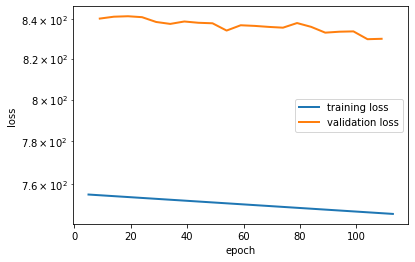

In [19]:
import matplotlib.pyplot as plt

val_len = len(loss_val)
print(val_len)
val_plt = np.zeros((2,val_len))
for i in range(val_len):
  val_plt[0,i] = loss_val[i][0]
  val_plt[1,i] = loss_val[i][1]

plt.figure()
plot_idx = np.arange(np.size(loss_optm))
# plt.plot(plot_idx,loss_optm,lw=2,label='training loss')
# plt.plot(val_plt[0,:],val_plt[1,:],lw=2,label='validation loss')
plt.plot(plot_idx[5:-1],loss_optm[5:-1],lw=2,label='training loss')
plt.plot(val_plt[0,1:],val_plt[1,1:],lw=2,label='validation loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show(block=False)

# from datetime import datetime
# now=datetime.now()
# timestamp=now.strftime('%Y%d%m%H%M%S')
# path='/content/drive/MyDrive/gnn/dnn_pytorch/gnn_%s.pickle'%(timestamp)
# # torch.save(net.state_dict(),path)
# path='/content/drive/MyDrive/gnn/dnn_pytorch/gnn_118_%s.pickle'%(timestamp)
# torch.save(net.state_dict(),path)
# path = '/content/drive/MyDrive/gnn/dnn_pytorch/gnn_118_20212205071835.pickle'
# net.load_state_dict(torch.load(path))

# Evaluate the model w/ validation set

In [20]:
# local_batch, local_labels = local_batch.to(device), local_labels.to(device)
# print(local_batch.shape)
# x_test_feed = x_test_feed.unsqueeze_(-1).transpose(1,2)
# print(x_test_feed.shape)

# print(local_batch.shape)

In [21]:
# validation_set = Dataset(features=x_test, labels=y_test)
# validation_generator = torch.utils.data.DataLoader(validation_set, **params)
# for local_batch, local_labels in validation_generator:
#   # Transfer to GPU
#   local_batch, local_labels = local_batch.to(device), local_labels.to(device)
#   logits = net(local_batch)

n_test = 2000

x_test_feed = torch.from_numpy(np.transpose(x_test)).float()
x_test_feed = x_test_feed#.transpose(1,2)
x_test_feed = x_test_feed.to(device)
print('Validation dataset size:',x_test_feed.shape)
print('Number of validation set: ',n_test)
# y_pred = np.zeros((x_test_feed.shape))
# for i in range(n_test):
#   y_pred[i,:] = net(x_test_feed[i,:])
y_pred = net(x_test_feed)

Validation dataset size: torch.Size([1600, 6, 118])
Number of validation set:  2000


* Visualization




 - Visualize errors

In [22]:
y_pred1 = y_pred.cpu().detach()
y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()
print(y_test.shape)

(118, 1600)


In [23]:
print(y_test.shape,y_pred1.shape)

(118, 1600) (118, 1600)


In [24]:
# for i in range(5):
#   print('sample',i)
#   print(y_test[:,i])
#   print(y_pred1[:,i])

In [25]:
n_test = np.size(y_test,1)
err_L2 = np.zeros(n_test)
err_Linf = np.zeros(n_test)
for i in range(n_test):
  err_L2[i] = np.linalg.norm(y_test[:,i] - y_pred1[:,i]) / np.linalg.norm(y_test[:,i])
  err_Linf[i] = np.max(np.abs(y_test[:,i] - y_pred1[:,i])) / np.max(np.abs(y_test[:,i]))

In [26]:
print(err_L2.shape,err_Linf.shape)

(1600,) (1600,)


L2 mean: 0.9937312990160794 L_inf mean: 0.9959891843854984


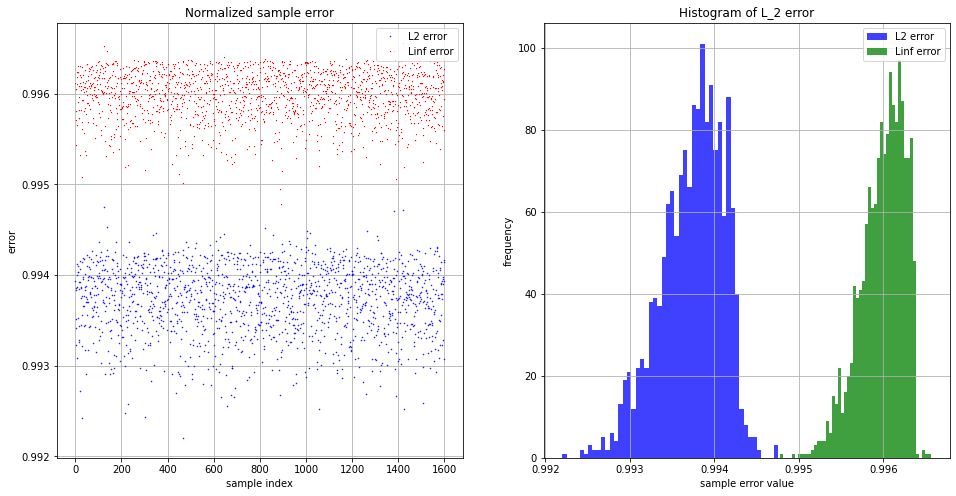

In [27]:
err_L2_mean = np.mean(err_L2)
err_Linf_mean = np.mean(err_Linf)
print('L2 mean:', err_L2_mean,'L_inf mean:', err_Linf_mean )

fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_L2,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_Linf,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(1, 2, 2)
plt.hist(err_L2, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_Linf, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

1600 L2 mean: 0.9937312990160794 1600 L_inf mean: 0.9959891843854984


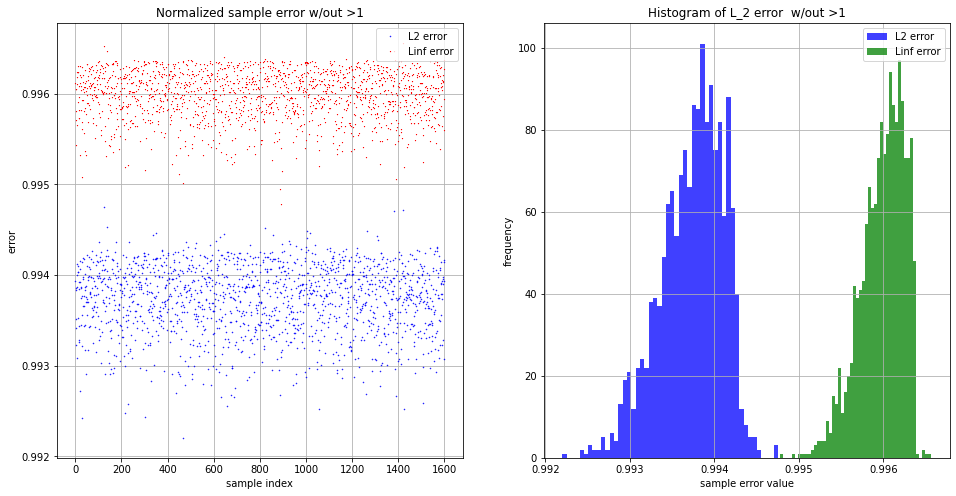

In [28]:
err_l2_new = [i for i in err_L2 if i < 1]
err_linf_new = [i for i in err_Linf if i < 1]
print(len(err_l2_new),'L2 mean:', np.mean(err_l2_new),len(err_linf_new),'L_inf mean:', np.mean(err_linf_new) )

fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_l2_new,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_linf_new,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error w/out >1')
plt.grid(True)
# error histogram
plt.subplot(1, 2, 2)
plt.hist(err_l2_new, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_linf_new, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error  w/out >1')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [29]:
print(x_train.shape)
# print(x_train[:,:,1].transpose())
# print(np.max(gen_limit0),np.min(err_linf_new))

(118, 6, 6400)


In [30]:
## LMP mismatch
# print(y_test[:,1], y_pred1[:,1])
index = 1
y_test_copy = y_pred1[:,index].copy()
print(y_test_copy.shape)
for i in range(118):
  if y_test_copy[i] < 0.1:
    y_test_copy[i] = y_test[i,index] + 50

print(np.linalg.norm(y_test_copy - y_test[:,index]) / np.linalg.norm(y_test[:,index]))

(118,)
0.993515778706157


In [31]:
# y_test_copy
# y_pred1[:,index]

# Predict generation using $\pi$
* Using predicted $\pi$ and find the active constraints in $p_G(i)$
* For inactive $p_G(i)$ consider other methods like power flow balance

In [32]:
gen_limit0 = x[:,4,:].copy() # lin cost
print(gen_limit0.shape)

gen_idx = []
gen_idx = np.arange(n_bus)
# for i in range(n_bus):
#   if gen_limit0[i,0] > 0:
#     gen_idx.append(i)
print(type(gen_idx),len(gen_idx),gen_idx)

(118, 8000)
<class 'numpy.ndarray'> 118 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117]


In [33]:
# # get the generator index
# # generator cost data
# gen_cost0
# # generator limit data
# gen_limit0
# # LMP data
# lmp_data
# # generation data
# gen_data

load_data = x.copy()
load_data = load_data[:,:]
print(load_data.shape)
n_sample = np.size(load_data,2)

# predict the corredponding LMP
x_val_feed = torch.from_numpy(np.transpose(load_data)).float()
batch_size=2000
y_pred1=[]
with torch.no_grad():
  for idx in range(0,x_val_feed.shape[0],batch_size):
    current_batch=x_val_feed[idx:idx+batch_size]
    current_batch=current_batch.to(device)
    current_y=net(current_batch)
    current_y=current_y.cpu().detach()
    current_y=torch.squeeze(current_y,1).numpy().tolist()
    y_pred1+=current_y
y_pred1=np.array(y_pred1).transpose()

print('Dataset size:',x_val_feed.shape)
print('Number of validation points:: ',n_sample)

# net1 = net.cpu()
# y_pred = net1(x_val_feed)

# y_pred1 = y_pred.cpu().detach()
print('output size',y_pred1.shape)
# y_pred1 = torch.squ[]eeze(y_pred1,1).numpy().transpose()
print('reshaped size',y_pred1.shape)

# load_data = x.copy()
# print(load_data.shape)
# n_sample = np.size(load_data,2)

# x_val_feed = torch.from_numpy(np.transpose(load_data)).float()
# x_val_feed = x_val_feed.to(device)

# print('Dataset size:',x_val_feed.shape)
# print('Number of validation points:: ',n_sample)
# y_pred = net(x_val_feed) # predict the corredponding LMP

# y_pred1 = y_pred.cpu().detach()
# print('output size',y_pred1.shape)
# y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()
# print('reshaped size',y_pred1.shape)

(118, 6, 8000)
Dataset size: torch.Size([8000, 6, 118])
Number of validation points::  8000
output size (118, 8000)
reshaped size (118, 8000)


* Save results

In [34]:
import pickle

In [35]:
# dataset = {'lmp_pred': y_pred1, 'lmp_true': lmp_data}
# print('Pred:',y_pred1.shape,'True:',lmp_data.shape)

# file_name = 'dc118_lmp_prediction_p10'
# file_path = 'drive/My Drive/gnn/data/results/'
# file_dir = file_path + file_name + '.pickle'
# outfile = open(file_dir, 'wb')
# pickle.dump(dataset, outfile)
# outfile.close()

In [36]:
gen_cost0 = x[:,4,:].copy()
lmp_data = y.copy()

quadratic_a = x[:,5,:].copy()

profit_pred = y_pred1 - gen_cost0
print(np.min(np.abs(profit_pred)))

profit_true = lmp_data - gen_cost0
print(np.min(np.abs(profit_true)))

profit_pred=(y_pred1-gen_cost0)/(quadratic_a+1e-10)/2
profit_true=(lmp_data-gen_cost0)/(quadratic_a+1e-10)/2
print(np.min(np.abs(profit_pred)))
print(np.min(np.abs(profit_true)))

2.7727346420288086
0.8119999999999976
5.797705230891584
0.26399635865374804


In [37]:
p_pred_sort = np.reshape(profit_pred,n_bus*n_sample)
p_true_sort = np.reshape(profit_true,n_bus*n_sample)
print(p_pred_sort.shape)

(944000,)


In [38]:
print(np.min(p_pred_sort),np.min(p_true_sort))

-8226.739400201855 -2.9391182643149665


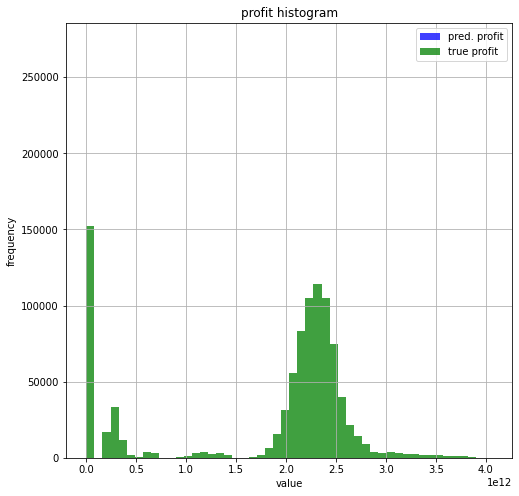

In [39]:
fig2 = plt.figure(figsize=(8, 8))
plt.hist(p_pred_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. profit')
plt.hist(p_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true profit')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('profit histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [40]:
# gen_pred_binary = np.zeros((len(gen_idx),n_sample))
# gen_true_binary = np.zeros((len(gen_idx),n_sample))
# print(gen_pred_binary.shape)

# binary_thres = 2.5
# binary_thres_true = 1e-5

# for i in range(n_sample):
#   for j in range(len(gen_idx)):
#     # predicted generator limit
#     if profit_pred[gen_idx[j],i] > binary_thres:
#       gen_pred_binary[j,i] = 1
#     elif profit_pred[gen_idx[j],i] < 0:
#       gen_pred_binary[j,i] = 0
#     else:
#       # gen_pred_binary[j,i] = (profit_pred[gen_idx[j],i] + binary_thres) / (2*binary_thres)
#       gen_pred_binary[j,i] = (profit_pred[gen_idx[j],i]) / (binary_thres)
#     # true generator limit
#     if profit_true[gen_idx[j],i] > binary_thres_true:
#       gen_true_binary[j,i] = 1
#     elif profit_true[gen_idx[j],i] < 0:
#       gen_true_binary[j,i] = 0
#     else:
#       gen_true_binary[j,i] = 0.5

# gen_binary_err = np.abs(gen_true_binary - gen_pred_binary)
# print('max binary error:',np.max(gen_binary_err))
# # count the wrong entries
# gen_binary_err_ct = np.sum(gen_binary_err)
# gen_binary_err_ratio = gen_binary_err_ct / (len(gen_idx)*n_sample)
# print('Binary accuracy:',1-gen_binary_err_ratio)

In [41]:
print(gen_limit0.shape)
print(np.transpose(x_test).shape,np.transpose(load_data).shape)

(118, 8000)
(1600, 6, 118) (8000, 6, 118)


 # Test flow feasibility

In [42]:
x[:,2,:].shape
profit_pred.shape
# n_sample

(118, 8000)

In [43]:
# x = [load, gen_cost, gen_lim]

# binary_thres = 0.97
binary_thres_true = 1e-5
# binary_thres = gen_limit0
binary_thres = x[:,0,:].copy() # upper
binary_thres_lo = x[:,1,:].copy() # lower

gen_pred_binary_full = np.zeros((n_bus,n_sample))
gen_true_binary_full = np.zeros((n_bus,n_sample))
# print(gen_pred_binary.shape,profit_pred.shape,gen_pred_binary_full.shape)

# x[:,2,:] # p_max

# ## generator injection
# for i in range(n_sample):
#   for j in range(len(gen_idx)):
#     # predicted generator limit
#     if profit_pred[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
#       gen_pred_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
#     elif profit_pred[gen_idx[j],i] < 0:
#       gen_pred_binary_full[gen_idx[j],i] = 0
#     else:
#       gen_pred_binary_full[gen_idx[j],i] = profit_pred[gen_idx[j],i]
#     # true generator limit
#     if profit_true[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
#       gen_true_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
#     elif profit_true[gen_idx[j],i] < 0:
#       gen_true_binary_full[gen_idx[j],i] = 0
#     else:
#       gen_true_binary_full[gen_idx[j],i] = profit_true[gen_idx[j],i]

## nodal injection
# gen_limit0 = x[:,2,:].copy()
for i in range(n_sample):
  for j in range(len(gen_idx)):
    # predicted generator limit
    if profit_pred[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_pred[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_pred_binary_full[gen_idx[j],i] = profit_pred[gen_idx[j],i]
    # true generator limit
    if profit_true[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_true[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_true_binary_full[gen_idx[j],i] = profit_true[gen_idx[j],i]


# injection by generators
# gen_inj = np.multiply(gen_pred_binary_full,gen_limit0)
# gen_inj_true = np.multiply(gen_true_binary_full,gen_limit0)
gen_inj=gen_pred_binary_full
gen_inj_true=gen_true_binary_full
# nodal injection
load0 = -x[:,1,:].copy() # load file
p_inj = gen_inj #- load0
p_inj_true = gen_inj_true #- load0

In [44]:
# load0 = x[:,0,:].copy()
print(np.sum(p_inj_true),np.sum(gen_inj_true))
print(np.sum(p_inj),np.sum(load0),np.sum(gen_inj))

2217585.044673539 2217585.044673539
-30776893.36058779 34540026.580000006 -30776893.36058779


* Calculate flow

In [45]:
n_line = np.size(S_isf,0)
flow_est = np.zeros((n_line,n_sample))
flow_est0 = np.zeros((n_line,n_sample))

f_binary = np.zeros((n_line,n_sample))
f_binary0 = np.zeros((n_line,n_sample))

# for i in range(n_sample):
flow_est = np.dot(S_isf,p_inj)
flow_est0 = np.dot(S_isf,p_inj_true)
# f_max
f_max_numpy = f_max.cpu().detach().numpy()
f_binary = (np.abs(flow_est)-f_max_numpy > 0)
f_binary0 = (np.abs(flow_est0)-f_max_numpy > 0)

In [46]:
f_tot_sample = n_line * n_sample
print(np.sum(f_binary),np.sum(f_binary0))
print(np.sum(f_binary)/f_tot_sample,np.sum(f_binary0)/f_tot_sample)

214320 11037
0.14403225806451614 0.007417338709677419


In [47]:
print(n_line,n_sample,flow_est.shape)

186 8000 (186, 8000)


In [48]:
# soft threshold
f_err_est = np.abs(flow_est)-f_max_numpy
f_err_true = np.abs(flow_est0)-f_max_numpy

f_err_est = np.maximum(np.abs(flow_est)-f_max_numpy,0) # identify violations
f_err_true = np.maximum(np.abs(flow_est0)-f_max_numpy,0)

print(np.max(f_err_est),np.max(f_err_true))
print(np.max(f_err_est/f_max_numpy),np.max(f_err_true/f_max_numpy))

# a= np.asarray([[1,2,1],[2,2,1]])
# b = np.asarray([1,1,1])
# c = (a-b>0)
# print(c)
# print(np.sum(c))

1017.5617301513726 39.54490583504514
4.078220960221222 0.2636327055669676


In [49]:
# f_binary_soft = (np.abs(flow_est)-f_max_numpy > 0.01*np.max(f_max_numpy))
# f_binary0_soft = (np.abs(flow_est0)-f_max_numpy > 0.01*np.max(f_max_numpy))
f_binary_soft = (np.abs(flow_est)-f_max_numpy > 0.1*(f_max_numpy))
f_binary0_soft = (np.abs(flow_est0)-f_max_numpy > 0.1*(f_max_numpy))
print(np.sum(f_binary_soft),np.sum(f_binary0_soft))
print(np.sum(f_binary_soft)/f_tot_sample,np.sum(f_binary0_soft)/f_tot_sample)

177147 8436
0.11905040322580646 0.005669354838709678


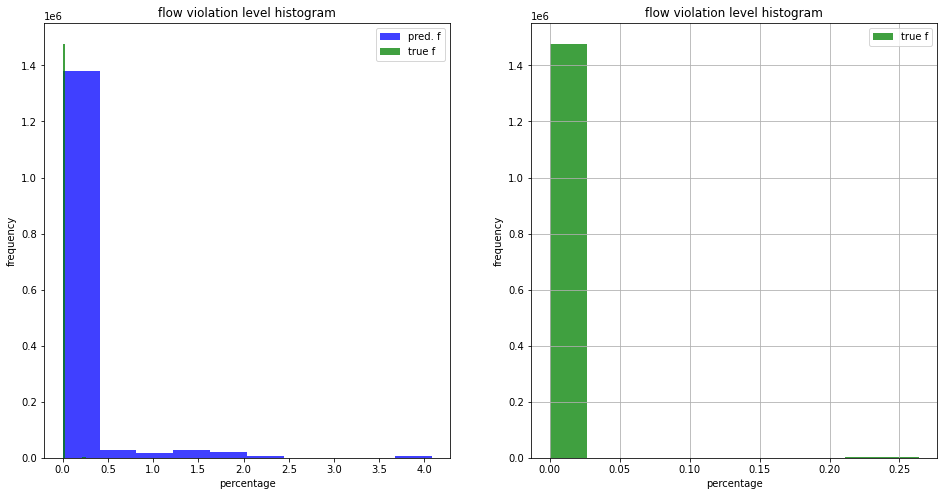

In [50]:
f_pred_sort = np.reshape(f_err_est/f_max_numpy,n_line*n_sample)
f_true_sort = np.reshape(f_err_true/f_max_numpy,n_line*n_sample)

fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.hist(f_pred_sort, bins = 10, facecolor='b', alpha=0.75,label = 'pred. f')
plt.hist(f_true_sort, bins = 10, facecolor='g', alpha=0.75,label = 'true f')
plt.legend(loc="upper right")
plt.xlabel('percentage')
plt.ylabel('frequency')
plt.title('flow violation level histogram')
plt.subplot(1,2,2)
plt.hist(f_true_sort, bins = 10, facecolor='g', alpha=0.75,label = 'true f')
plt.legend(loc="upper right")
plt.xlabel('percentage')
plt.ylabel('frequency')
plt.title('flow violation level histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [51]:
f_line = np.sum(f_binary,0)
f_samp = np.sum(f_binary,1)
print('max sample pred:',np.max(f_line))
print('max line pred:',np.max(f_samp))

f_line0  = np.sum(f_binary0,0)
f_samp0 = np.sum(f_binary0,1)
print('max sample true:',np.max(f_line0))
print('max line true:',np.max(f_samp0))

max sample pred: 28
max line pred: 8000
max sample true: 3
max line true: 8000
